# Machine Learning Examination - Question 1

**DOCUMENTATION DONE AT THE VERY BOTTOM.**

In [1]:
# Imports
% matplotlib notebook
import os
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score as r2_s
from sklearn.metrics import mean_squared_error as m_s_e

In [2]:
# Fetch Dataset Location
data_path = '.\\Exam Datasets'
filename = 'regression_data.csv'
data_file = os.path.join(data_path, filename)

In [3]:
# Selecting Columns for Dataset - Feature Selection
cols = ['bedrooms', 'bathrooms', 
        'floors', 'condition', 'grade', 
        'sqft_above', 'sqft_basement', 'yr_built', 
        'sqft_living15', 'sqft_lot15', 'price']

In [4]:
# Get the Dataset
dataset = pd.read_csv(data_file, usecols=cols)

In [5]:
# Take 'yr_built' as Age of House - Header Not Renamed or No New Column Created
# Heading Preserved - Values Changed
now = datetime.datetime.now()
dataset['yr_built'] = now.year - dataset['yr_built']

<IPython.core.display.Javascript object>


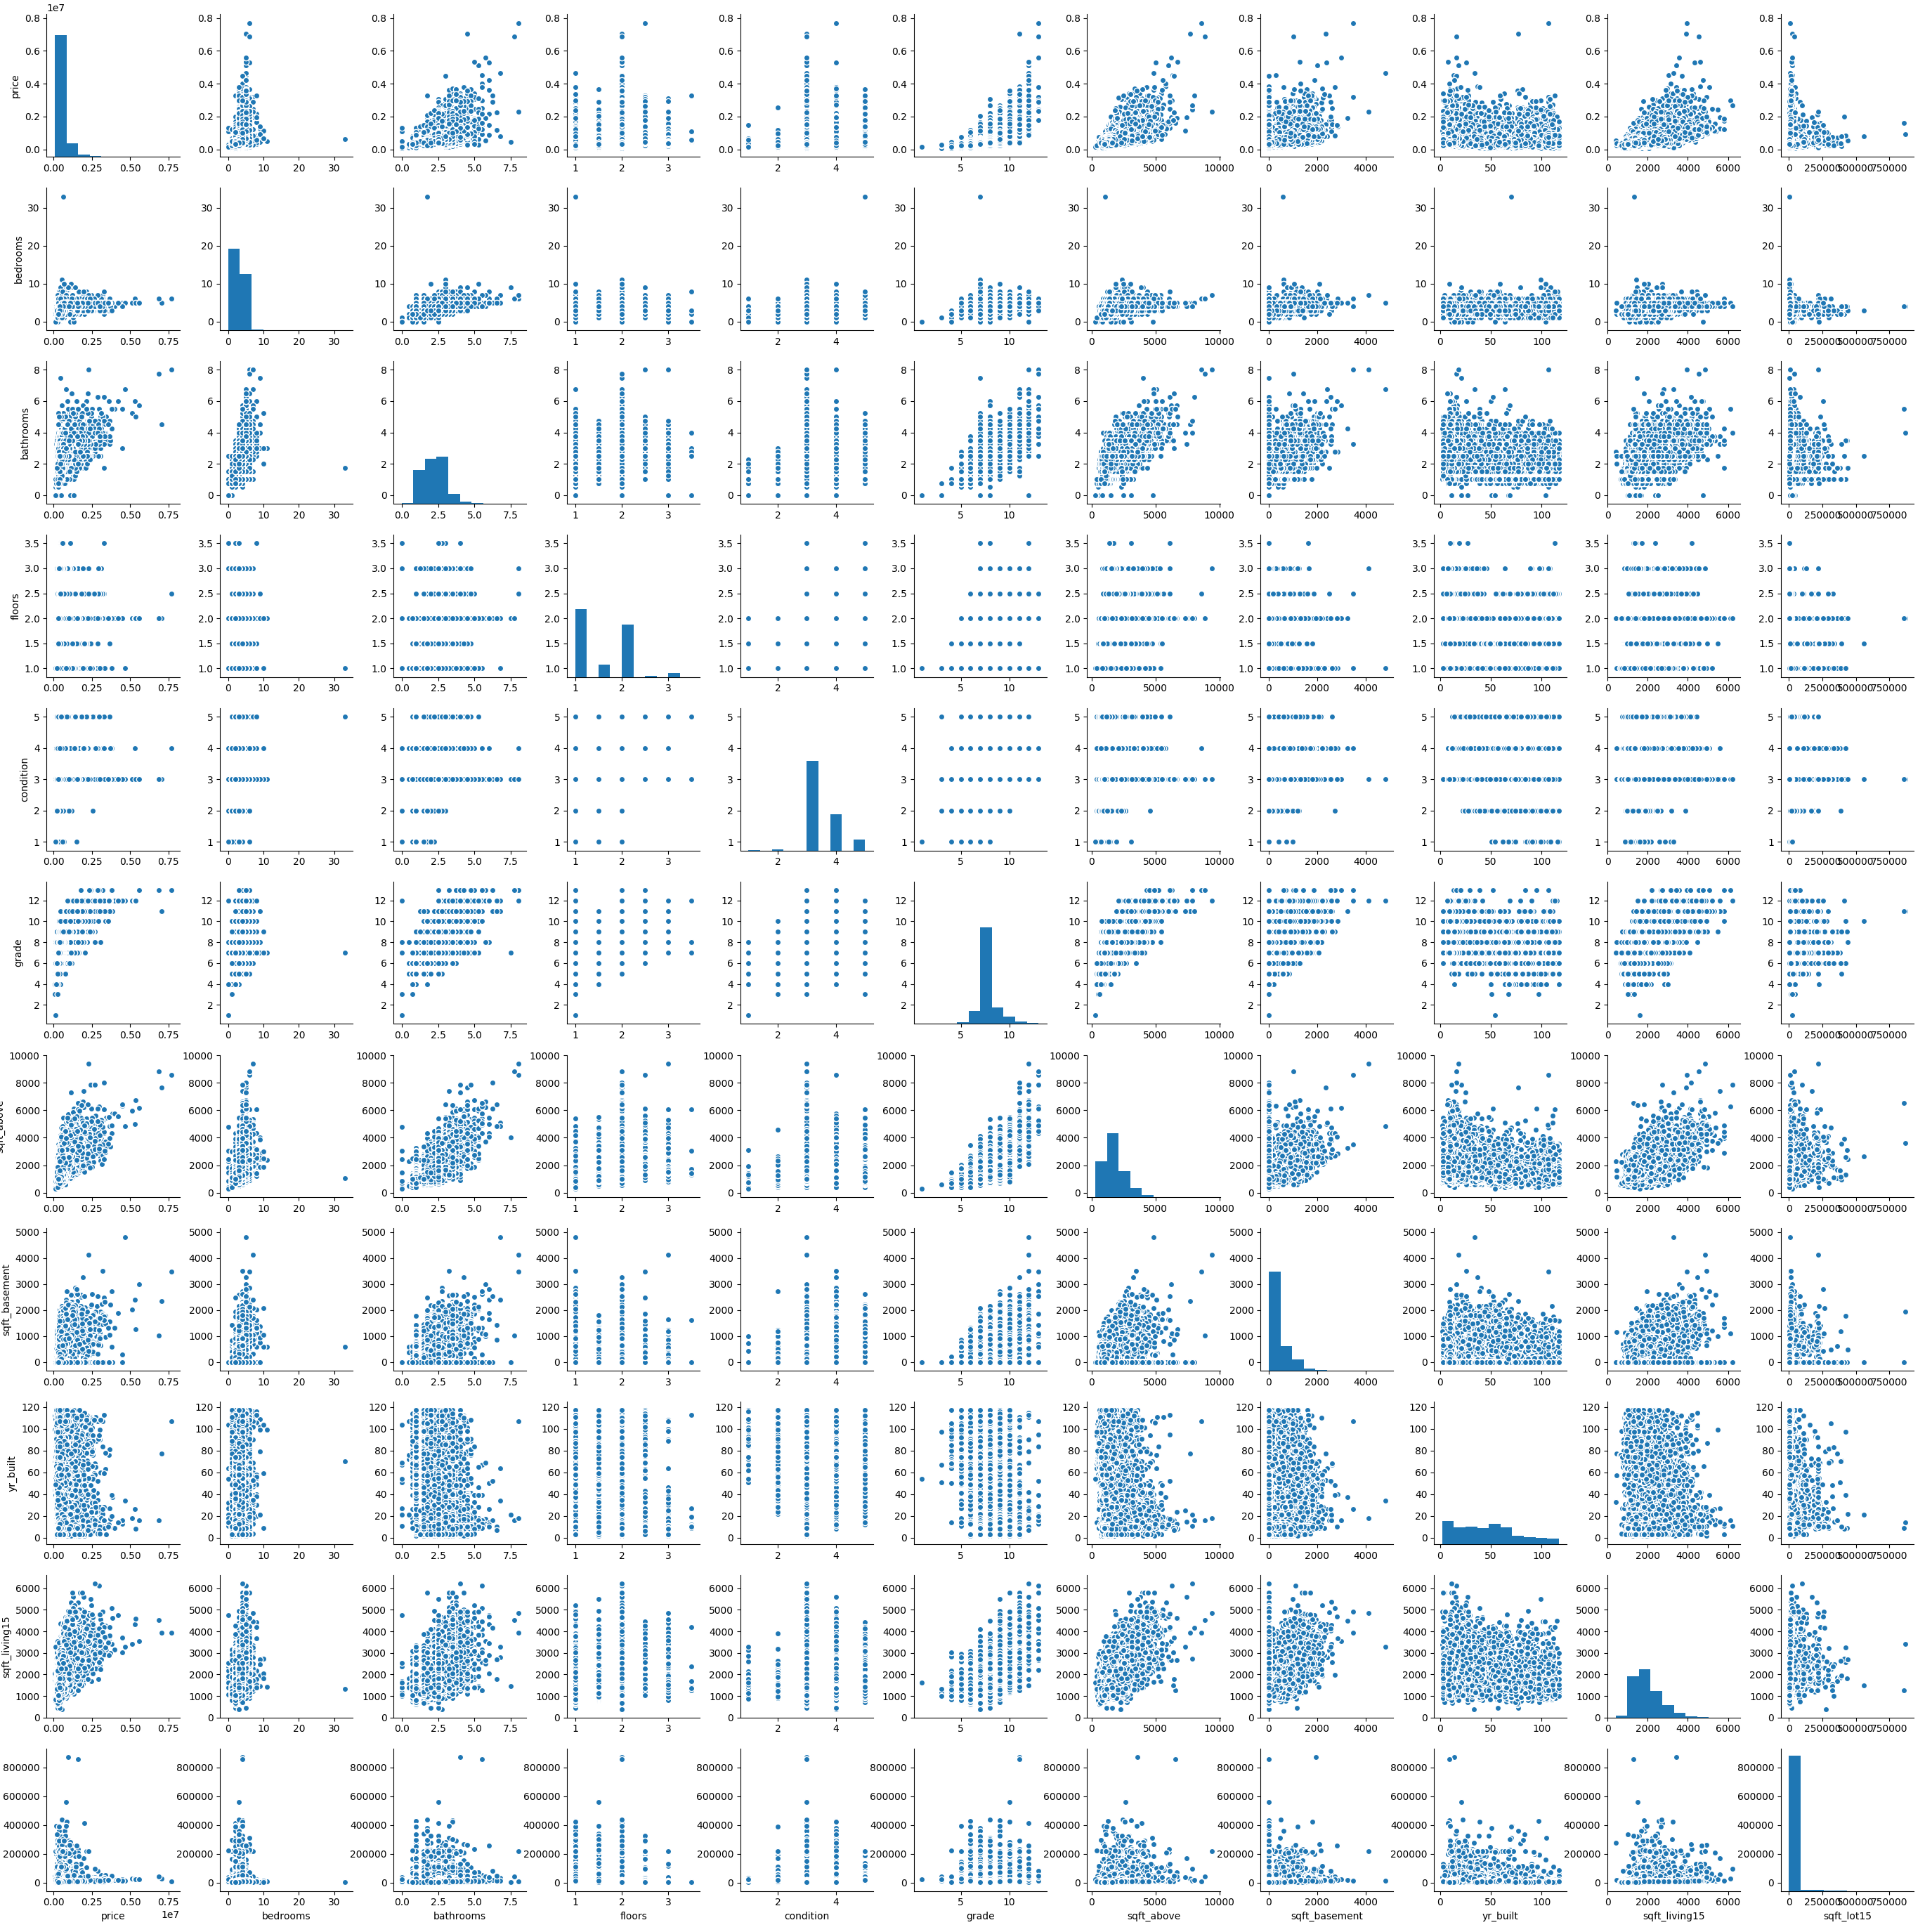

In [6]:
# Plot Dataset Before Normalizing/Scaling the Values
sns.pairplot(dataset) # Scatters and Histograms

In [7]:
# A Function to Normalize the Dataset Columns taken to a range of 0 to 1.
def normalize(dataset, data_columns):
    for dc in data_columns:
        attribute = np.asarray([row[dc] for index, row in dataset.iterrows()])
        min_attr, max_attr = np.min(attribute), np.max(attribute)
        attr_norm = np.interp(attribute, [min_attr, max_attr], [0, 1])
        dataset[dc] = attr_norm
    return dataset

In [8]:
# Normalization of Dataset
dataset = normalize(dataset, cols)

<IPython.core.display.Javascript object>


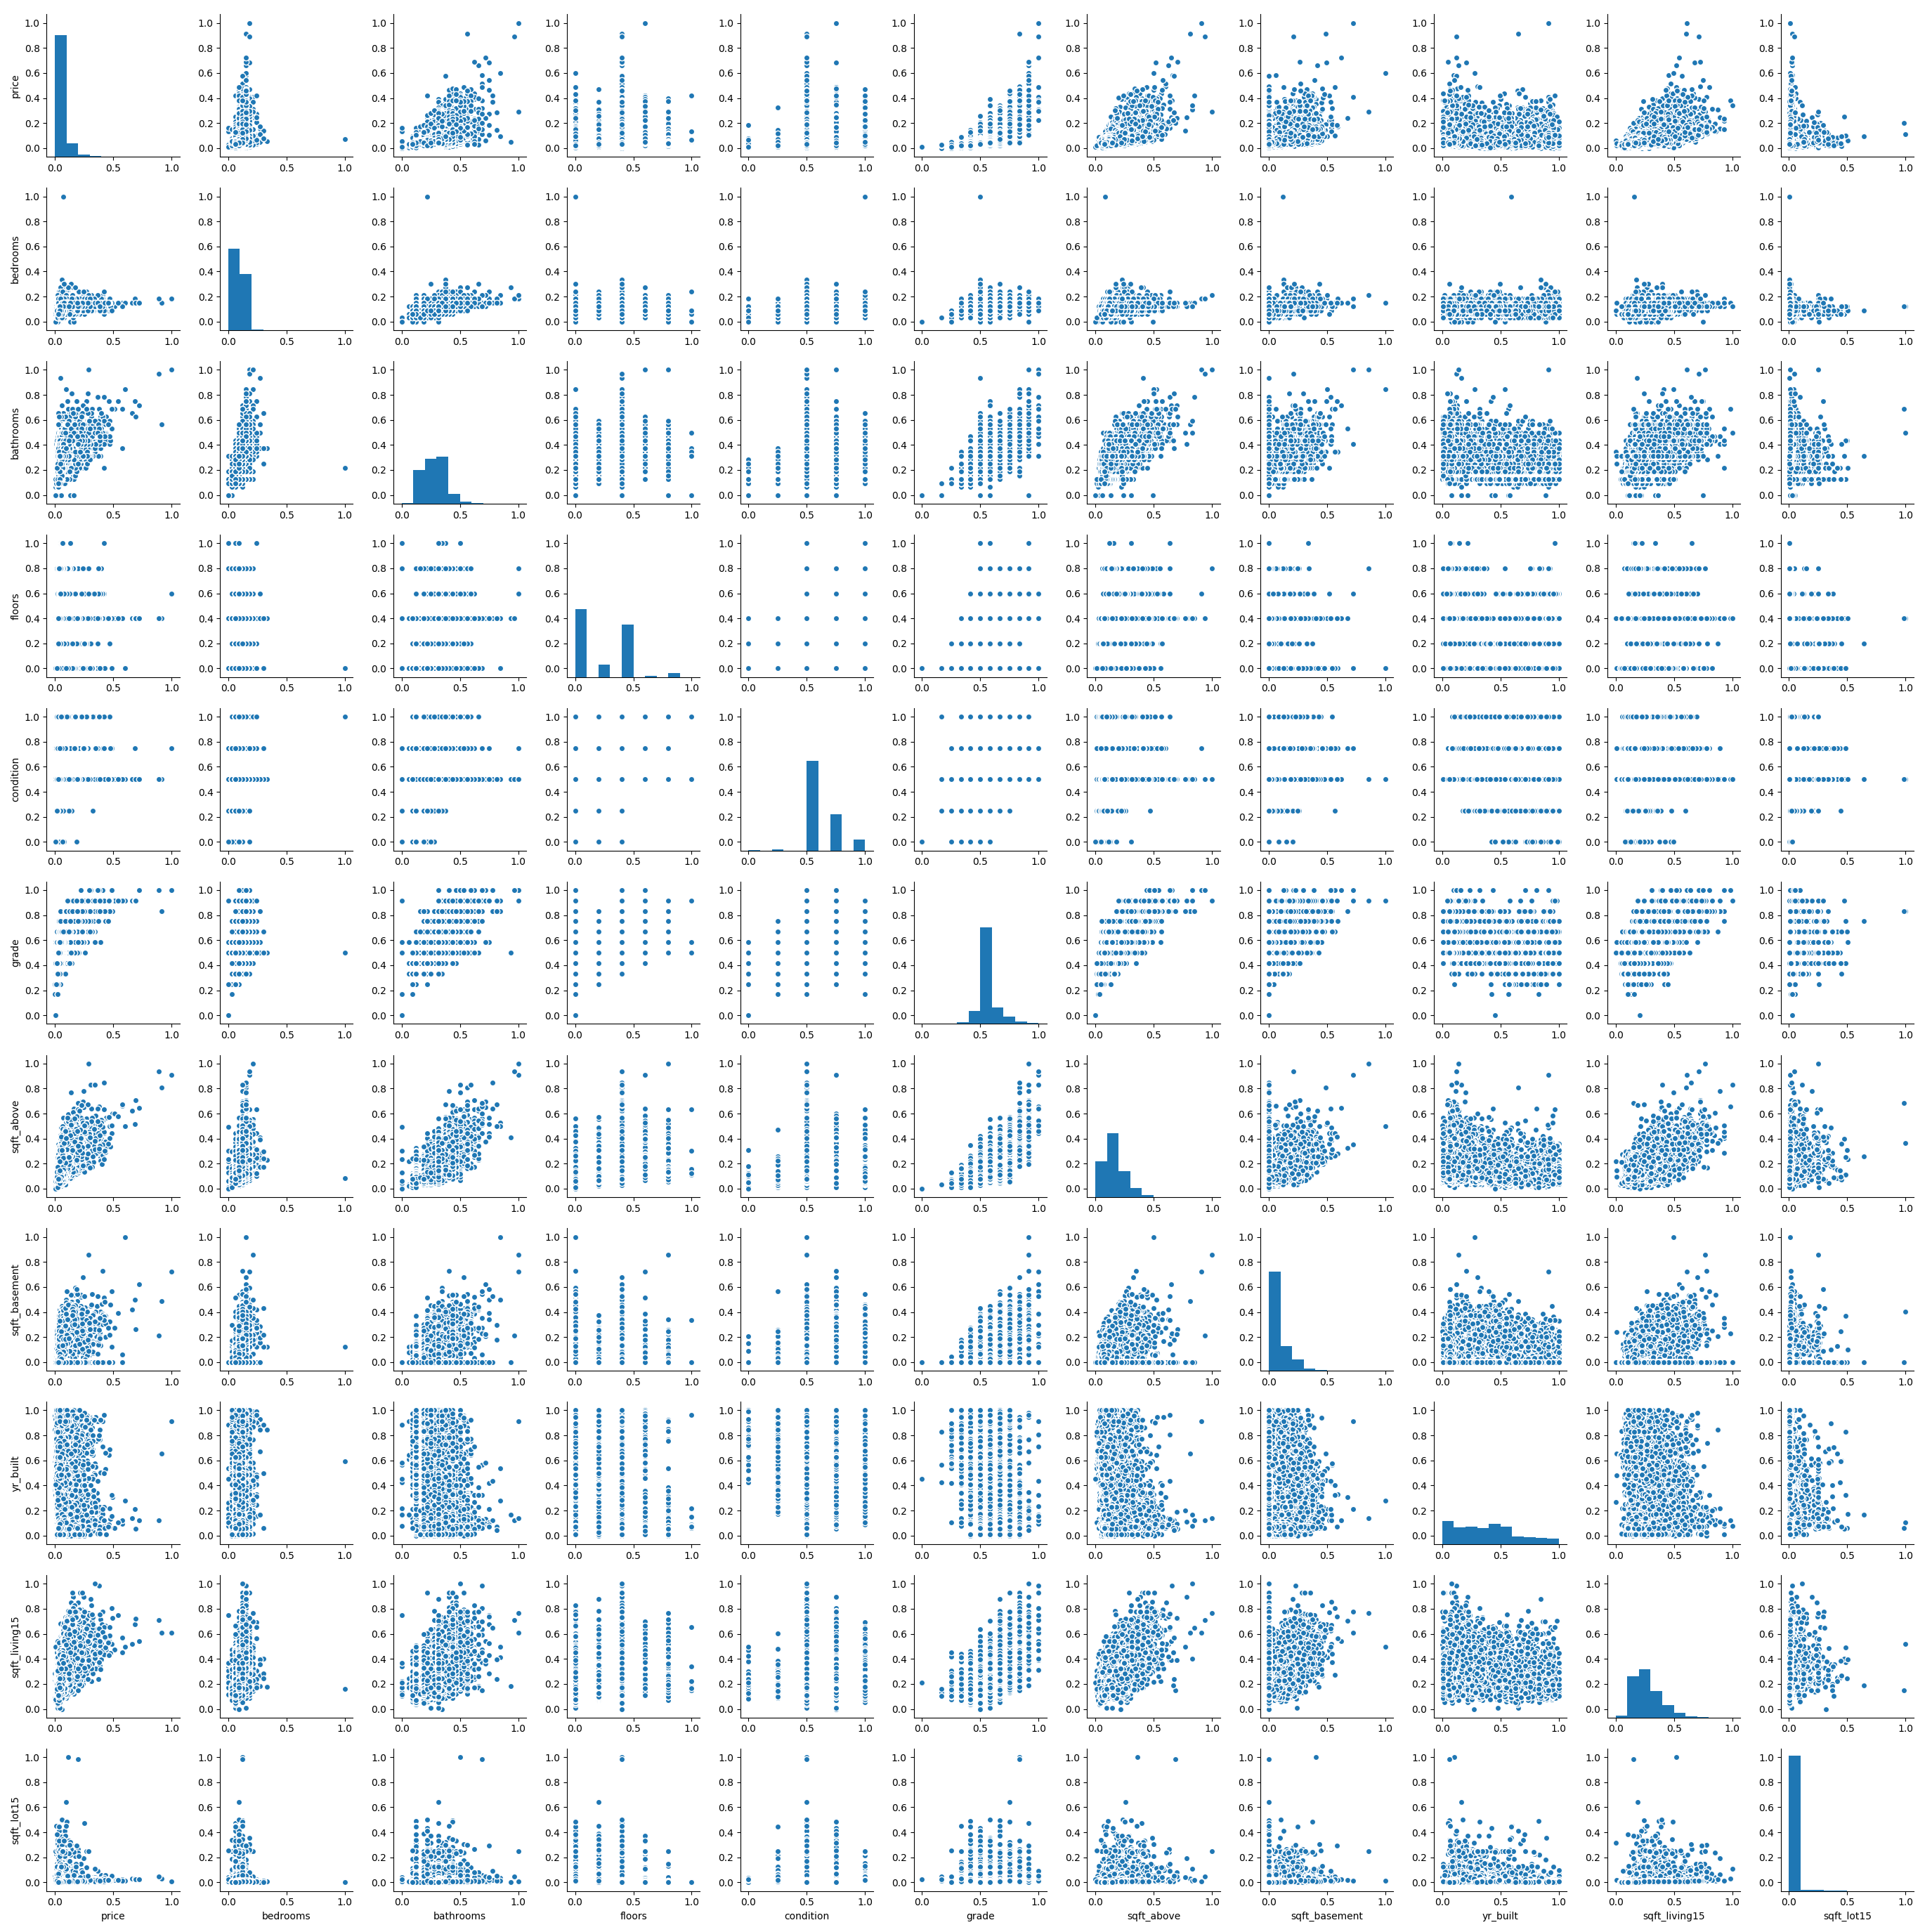

In [9]:
# Plot Dataset After Normalizing/Scaling the Values
sns.pairplot(dataset) # Scatters and Histograms

In [10]:
# Dataset Visualization and Analysis
data_head = dataset.head()
print ('\n Dataset Head :')
print (data_head)
data_tail = dataset.tail()
print ('\n Dataset Tail :')
print (data_tail)
data_desc = dataset.describe()
print ('\n Dataset Description :')
print (data_desc)
data_corr = dataset.corr()
print ('\n Dataset Correlation :')
print (data_corr)


 Dataset Head :
      price  bedrooms  bathrooms  floors  condition     grade  sqft_above  \
0  0.019266  0.090909    0.12500     0.0        0.5  0.500000    0.097588   
1  0.060721  0.090909    0.28125     0.4        0.5  0.500000    0.206140   
2  0.013770  0.060606    0.12500     0.0        0.5  0.416667    0.052632   
3  0.069377  0.121212    0.37500     0.0        1.0  0.500000    0.083333   
4  0.057049  0.090909    0.25000     0.0        0.5  0.583333    0.152412   

   sqft_basement  yr_built  sqft_living15  sqft_lot15  
0       0.000000  0.521739       0.161934    0.005742  
1       0.082988  0.556522       0.222165    0.008027  
2       0.000000  0.713043       0.399415    0.008513  
3       0.188797  0.434783       0.165376    0.004996  
4       0.000000  0.243478       0.241094    0.007871  

 Dataset Tail :
          price  bedrooms  bathrooms  floors  condition     grade  sqft_above  \
21608  0.037377  0.090909    0.31250     0.8        0.5  0.583333    0.135965   
21609

<IPython.core.display.Javascript object>


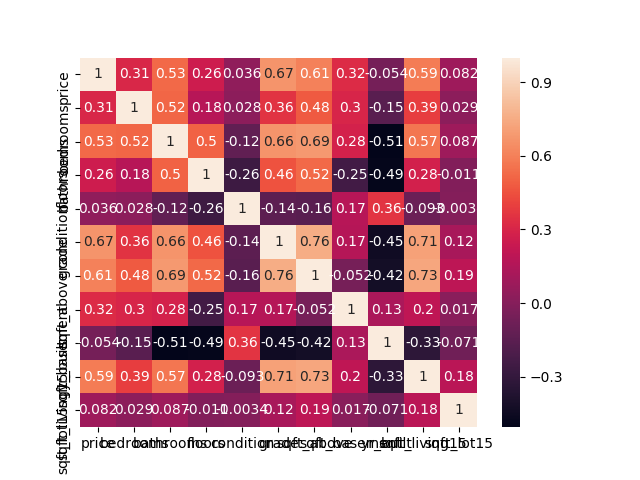

In [11]:
# HeatMap Figure of Correlation of Selected Features
plt.figure()
sns.heatmap(data_corr, annot=True)

In [12]:
# Shuffling Dataset to Desquence any Ordered Data
dataset = shuffle(dataset)

In [13]:
#  A Function to Split Dataset to Train and Test Sets
def train_test_split(dataset):
    percent = 0.80
    data_train = dataset[ : int(percent * dataset.shape[0])]
    data_test = dataset[int(percent * dataset.shape[0]) : ]
    return data_train, data_test

In [14]:
# A Function to Split Passed Dataset to K-Folds.
def split_kfold(dataset, folds):
    l = dataset.shape[0]
    s = (1.0 / folds)
    splits = []
    for k in range(folds):
        split = dataset[int(k * s * l) : int((k + 1) * s * l)]
        splits.append(split)
    return splits

In [15]:
# A Function to Obtain the Features and Target List
def get_X_Y(dataset):
    X = np.asarray([[row['bedrooms'], row['bathrooms'], 
                     row['floors'], row['condition'], 
                     row['grade'], row['sqft_above'], 
                     row['sqft_basement'], row['yr_built'], 
                     row['sqft_living15'], row['sqft_lot15']] for index, row in dataset.iterrows()])
    Y = np.asarray([row['price'] for index, row in dataset.iterrows()])
    return X, Y

In [16]:
# Spliting the Dataset
# Initial Split of Dataset to Train and Test
data_cv, data_test = train_test_split(dataset)
# Obtaining Cross Validation Splits for CV Dataset
cv_splits = split_kfold(data_cv, 5)
# Obtaining Train Features and Target
cv_train_X, cv_train_Y = get_X_Y(data_cv)
# Obtaining Test Features and Target
test_X, test_Y = get_X_Y(data_test)

**Ordinary Least Squares Regression**

In [17]:
# Ordinary Least Squares Regression
ols = LinearRegression() # OLS Initializer

In [18]:
# Train
tols = time.time()
# Lists to collect Mean Squared Error, Root MSE, R^2 Scores to Average later
mses, rmses, rsqs = [], [], []
# Performing Cross Validation on CV Data Splits
for i in range(len(cv_splits)):
    print ('CV Epoch : ' + str(i + 1))
    cv_train, cv_test = train_test_split(cv_splits[i])
    cv_train_X, cv_train_Y = get_X_Y(cv_train)
    cv_test_X, cv_test_Y = get_X_Y(cv_test)
    ols_fit = ols.fit(cv_train_X, cv_train_Y)
    cv_pred = ols.predict(cv_test_X)
    # The Coefficients
    print ('Coefficients : \n', ols.coef_)
    # Mean Squared Error
    mse = float(m_s_e(cv_test_Y, cv_pred))
    print ('Mean Squared Error : %f' % mse)
    # Root Mean Squared Error
    rmse = float(np.sqrt(m_s_e(cv_test_Y, cv_pred)))
    print ('Root Mean Squared Error : %f' % rmse)
    # R^2 (Coefficient of Determination) Regression Score
    rsq = float(r2_s(cv_test_Y, cv_pred))
    print ('R^2 Regression Score : %f' % rsq)
    # Appending MSE, RMSE, R^2 values to List
    mses.append(mse)
    rmses.append(rmse)
    rsqs.append(rsq)
    print ()
tols = time.time() - tols
print ('Time Taken To Train : %f Secs.' % tols)

CV Epoch : 1
Coefficients : 
 [-0.24715835  0.06629054  0.00666749  0.01356461  0.18965457  0.23812961
  0.12348075  0.06203788  0.02189703 -0.06525342]
Mean Squared Error : 0.000847
Root Mean Squared Error : 0.029097
R^2 Regression Score : 0.566571

CV Epoch : 2
Coefficients : 
 [-0.22138307  0.03285876  0.0174645   0.00894974  0.19123904  0.16652296
  0.13539518  0.05806245  0.04737699 -0.02641309]
Mean Squared Error : 0.000687
Root Mean Squared Error : 0.026215
R^2 Regression Score : 0.599752

CV Epoch : 3
Coefficients : 
 [-0.3022615   0.04999399  0.00314548  0.00727371  0.19360929  0.26519555
  0.12004485  0.06108857  0.01453623 -0.09699807]
Mean Squared Error : 0.001283
Root Mean Squared Error : 0.035820
R^2 Regression Score : 0.597147

CV Epoch : 4
Coefficients : 
 [-0.21740941  0.04106917  0.01810321  0.0068347   0.18508978  0.19953293
  0.12927877  0.05773541  0.02023658 -0.04355376]
Mean Squared Error : 0.000846
Root Mean Squared Error : 0.029078
R^2 Regression Score : 0.6443

In [19]:
# Calculation of Average Metrics after CV
print ('Average Mean Squared Error : %f' % np.mean(mses))
print ('Average Root Mean Squared Error : %f' % np.mean(rmses))
print ('Average R^2 Regression Score : %f' % np.mean(rsqs))
print ()

Average Mean Squared Error : 0.000909
Average Root Mean Squared Error : 0.029986
Average R^2 Regression Score : 0.601381



In [20]:
# Test and Results
tols = time.time()
test_pred = ols.predict(test_X)
tols = time.time() - tols
print ('Time Taken To Test : %f Secs.' % tols)
# The Coefficients
print ('Test Coefficients : \n', ols.coef_)
# Mean Squared Error
mse = float(m_s_e(test_Y, test_pred))
print ('Test Mean Squared Error : %f' % mse)
# Root Mean Squared Error
rmse = float(np.sqrt(m_s_e(test_Y, test_pred)))
print ('Test Root Mean Squared Error : %f' % rmse)
# R^2 (Coefficient of Determination) Regression Score
rsq = float(r2_s(test_Y, test_pred))
print ('Test R^2 Regression Score : %f' % rsq)
print ()

Time Taken To Test : 0.001005 Secs.
Test Coefficients : 
 [-0.14772337  0.04732958  0.01126319  0.00792986  0.2177466   0.15024569
  0.1096297   0.05788943  0.03762679 -0.0405528 ]
Test Mean Squared Error : 0.000932
Test Root Mean Squared Error : 0.030534
Test R^2 Regression Score : 0.624678



**Lasso Regression**

In [21]:
# Lasso Regression
# Functions and Parameters
alphas = np.array([0.001, 0.01, 0.1, 1.0, 2.0])
lasso = Lasso(alpha=alphas)
tuned_parameters = {'alpha': alphas}
# Lasso Initializer
lso_clf = GridSearchCV(lasso, tuned_parameters, cv=5)
print ()

In [22]:
# Train
tlso = time.time()
lso_fit = lso_clf.fit(cv_train_X, cv_train_Y)
tlso = time.time() - tlso
print ('Time Taken To Train : %f Secs.' % tlso)
lso_results = lso_clf.cv_results_
print ('Lasso CV Results : \n', lso_results)
lso_params = lso_clf.best_params_
print ('Lasso Best Parameters : \n', lso_params)
lso_score = lso_clf.best_score_
print ('Lasso Best Score : \n', lso_score)
print ()

Time Taken To Train : 0.098070 Secs.
Lasso CV Results : 
 {'mean_fit_time': array([ 0.00220222,  0.00120091,  0.00100131,  0.00120091,  0.00119977]), 'std_fit_time': array([  9.81282647e-04,   4.00304809e-04,   1.02713867e-06,
         3.99947575e-04,   3.98254937e-04]), 'mean_score_time': array([ 0.00120034,  0.00020218,  0.00060139,  0.00060015,  0.00039964]), 'std_score_time': array([ 0.0007488 ,  0.00040436,  0.00049103,  0.00049002,  0.00048945]), 'param_alpha': masked_array(data = [0.001 0.01 0.10000000000000001 1.0 2.0],
             mask = [False False False False False],
       fill_value = ?)
, 'params': [{'alpha': 0.001}, {'alpha': 0.01}, {'alpha': 0.10000000000000001}, {'alpha': 1.0}, {'alpha': 2.0}], 'split0_test_score': array([ 0.46599943, -0.00122347, -0.00122347, -0.00122347, -0.00122347]), 'split1_test_score': array([ 0.46033818, -0.00476889, -0.00476889, -0.00476889, -0.00476889]), 'split2_test_score': array([ 0.43273906, -0.00247749, -0.00247749, -0.00247749, -0.0024

In [23]:
# Test and Results
tlso = time.time()
test_pred = lso_clf.predict(test_X)
tlso = time.time() - tlso
print ('Time Taken To Test : %f Secs.' % tlso)
# The Best Estimator
print ('Test Estimator : \n', lso_clf.best_estimator_)
# Mean Squared Error
mse = float(m_s_e(test_Y, test_pred))
print ('Test Mean Squared Error : %f' % mse)
# Root Mean Squared Error
rmse = float(np.sqrt(m_s_e(test_Y, test_pred)))
print ('Test Root Mean Squared Error : %f' % rmse)
# R^2 (Coefficient of Determination) Regression Score
rsq = float(r2_s(test_Y, test_pred))
print ('Test R^2 Regression Score : %f' % rsq)
print ()

Time Taken To Test : 0.001004 Secs.
Test Estimator : 
 Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Test Mean Squared Error : 0.001372
Test Root Mean Squared Error : 0.037043
Test R^2 Regression Score : 0.447597



**Linear Kernel Ridge Regression**

In [24]:
# Linear Kernel Ridge Regression
print ()
# Functions and Parameters
alphas = [1.0]
lin_krr = KernelRidge(alpha=alphas, kernel='linear')
hyperparams = {'alpha' : alphas}
# Linear KRR Initializer
lin_krr_clf = GridSearchCV(lin_krr, hyperparams, cv=5)

In [25]:
# Train
tl = time.time()
lin_krr_fit = lin_krr_clf.fit(cv_train_X, cv_train_Y)
tl = time.time() - tl
print ('Time Taken To Train : %f Secs.' % tl)
lin_krr_res = lin_krr_clf.cv_results_
print ('Linear KRR CV Results : \n', lin_krr_res)
lin_krr_params = lin_krr_clf.best_params_
print ('Linear KRR Best Parameters : \n', lin_krr_params)
lin_krr_score = lin_krr_clf.best_score_
print ('Linear KRR Best Score : \n', lin_krr_score)
print ()

Time Taken To Train : 3.921671 Secs.
Linear KRR CV Results : 
 {'mean_fit_time': array([ 0.50005918]), 'std_fit_time': array([ 0.0687962]), 'mean_score_time': array([ 0.01453276]), 'std_score_time': array([ 0.00237756]), 'param_alpha': masked_array(data = [1.0],
             mask = [False],
       fill_value = ?)
, 'params': [{'alpha': 1.0}], 'split0_test_score': array([ 0.53556741]), 'split1_test_score': array([ 0.5216432]), 'split2_test_score': array([ 0.50600565]), 'split3_test_score': array([ 0.58152003]), 'split4_test_score': array([ 0.52032046]), 'mean_test_score': array([ 0.53301227]), 'std_test_score': array([ 0.02599237]), 'rank_test_score': array([1]), 'split0_train_score': array([ 0.5401433]), 'split1_train_score': array([ 0.54316851]), 'split2_train_score': array([ 0.54788242]), 'split3_train_score': array([ 0.52866374]), 'split4_train_score': array([ 0.54561384]), 'mean_train_score': array([ 0.54109436]), 'std_train_score': array([ 0.00672652])}
Linear KRR Best Parameters 

In [26]:
# Test and Results
tl = time.time()
test_pred = lin_krr_clf.predict(test_X)
tl = time.time() - tl
print ('Time Taken To Test : %f Secs.' % tl)
# The Best Estimator
print ('Test Estimator : \n', lin_krr_clf.best_estimator_)
# Mean Squared Error
mse = float(m_s_e(test_Y, test_pred))
print ('Test Mean Squared Error : %f' % mse)
# Root Mean Squared Error
rmse = float(np.sqrt(m_s_e(test_Y, test_pred)))
print ('Test Root Mean Squared Error : %f' % rmse)
# R^2 (Coefficient of Determination) Regression Score
rsq = float(r2_s(test_Y, test_pred))
print ('Test R^2 Regression Score : %f' % rsq)
print ()

Time Taken To Test : 0.145103 Secs.
Test Estimator : 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)
Test Mean Squared Error : 0.001121
Test Root Mean Squared Error : 0.033476
Test R^2 Regression Score : 0.548858



**Polynomial Kernel Ridge Regression**

In [27]:
# Polynomial Kernel Ridge Regression
print ()
# Functions and Parameters
alphas = [1.0]
degs = [2.0, 4.0, 7.0] # M
hyperparams = {'alpha' : alphas, 'degree' : degs}
poly_krr = KernelRidge(kernel='poly', alpha=alphas, degree=degs, gamma=1, coef0=1)
# Polynomial KRR Initializer
poly_krr_clf = GridSearchCV(poly_krr, hyperparams, cv=5)

In [28]:
# Train
tp = time.time()
poly_krr_fit = poly_krr_clf.fit(cv_train_X, cv_train_Y)
tp = time.time() - tp
print ('Time Taken To Train : %f Secs.' % tp)
poly_krr_res = poly_krr_clf.cv_results_
print ('Polynomial KRR CV Results : \n', poly_krr_res)
poly_krr_params = poly_krr_clf.best_params_
print ('Polynomial KRR Best Parameters : \n', poly_krr_params)
poly_krr_score = poly_krr_clf.best_score_
print ('Polynomial KRR Best Score : \n', poly_krr_score)
print ()

Time Taken To Train : 31.144149 Secs.
Polynomial KRR CV Results : 
 {'mean_fit_time': array([ 0.80665359,  1.14378633,  1.26810646]), 'std_fit_time': array([ 0.18790667,  0.13807228,  0.11154051]), 'mean_score_time': array([ 0.02438693,  0.11637573,  0.14843469]), 'std_score_time': array([ 0.00527367,  0.02146753,  0.01077903]), 'param_alpha': masked_array(data = [1.0 1.0 1.0],
             mask = [False False False],
       fill_value = ?)
, 'param_degree': masked_array(data = [2.0 4.0 7.0],
             mask = [False False False],
       fill_value = ?)
, 'params': [{'alpha': 1.0, 'degree': 2.0}, {'alpha': 1.0, 'degree': 4.0}, {'alpha': 1.0, 'degree': 7.0}], 'split0_test_score': array([ 0.53632249,  0.55238117, -1.15421757]), 'split1_test_score': array([ 0.69213613,  0.73161583,  0.04630272]), 'split2_test_score': array([ 0.65560542,  0.71792519,  0.72608911]), 'split3_test_score': array([ 0.73686589,  0.68474553,  0.63480038]), 'split4_test_score': array([ 0.6790215 ,  0.70233199,  

In [29]:
# Test and Results
tp = time.time()
test_pred = poly_krr_clf.predict(test_X)
tp = time.time() - tp
print ('Time Taken To Test : %f Secs.' % tp)
# The Best Estimator
print ('Test Estimator : \n', poly_krr_clf.best_estimator_)
# Mean Squared Error
mse = float(m_s_e(test_Y, test_pred))
print ('Test Mean Squared Error : %f' % mse)
# Root Mean Squared Error
rmse = float(np.sqrt(m_s_e(test_Y, test_pred)))
print ('Test Root Mean Squared Error : %f' % rmse)
# R^2 (Coefficient of Determination) Regression Score
rsq = float(r2_s(test_Y, test_pred))
print ('Test R^2 Regression Score : %f' % rsq)
print ()

Time Taken To Test : 1.455246 Secs.
Test Estimator : 
 KernelRidge(alpha=1.0, coef0=1, degree=4.0, gamma=1, kernel='poly',
      kernel_params=None)
Test Mean Squared Error : 0.000697
Test Root Mean Squared Error : 0.026395
Test R^2 Regression Score : 0.719519



**Gaussian/RBF Kernel Ridge Regression**

In [30]:
# Gaussian/RBF Kernel Ridge Regression
print ()
# Functions and Parameters
alphas = [1.0]
sigmas = [0.1, 0.5, 1.0, 2.0, 4.0]
hyperparams = {'alpha' : alphas, 'gamma' : sigmas}
rbf_krr = KernelRidge(kernel='rbf', alpha=alphas, gamma=sigmas)
# Gaussian/RBF KRR Initializer
rbf_krr_clf = GridSearchCV(rbf_krr, hyperparams, cv=5)

In [31]:
# Train
tg = time.time()
rbf_krr_fit = rbf_krr_clf.fit(cv_train_X, cv_train_Y)
tg = time.time() - tg
print ('Time Taken To Train : %f Secs.' % tg)
rbf_krr_res = rbf_krr_clf.cv_results_
print ('Gaussian KRR CV Results : \n', rbf_krr_res)
rbf_krr_params = rbf_krr_clf.best_params_
print ('Gaussian KRR Best Parameters : \n', rbf_krr_params)
rbf_krr_score = rbf_krr_clf.best_score_
print ('Gaussian KRR Best Score : \n', rbf_krr_score)
print ()

Time Taken To Train : 31.194057 Secs.
Gaussian KRR CV Results : 
 {'mean_fit_time': array([ 1.10421152,  0.86332664,  0.72175865,  0.89458489,  0.7593606 ]), 'std_fit_time': array([ 0.4204391 ,  0.0870289 ,  0.12946748,  0.11677996,  0.07919346]), 'mean_score_time': array([ 0.08151464,  0.05013132,  0.05242276,  0.05355196,  0.05631247]), 'std_score_time': array([ 0.03080651,  0.01063812,  0.0107412 ,  0.00300957,  0.00758272]), 'param_alpha': masked_array(data = [1.0 1.0 1.0 1.0 1.0],
             mask = [False False False False False],
       fill_value = ?)
, 'param_gamma': masked_array(data = [0.1 0.5 1.0 2.0 4.0],
             mask = [False False False False False],
       fill_value = ?)
, 'params': [{'alpha': 1.0, 'gamma': 0.1}, {'alpha': 1.0, 'gamma': 0.5}, {'alpha': 1.0, 'gamma': 1.0}, {'alpha': 1.0, 'gamma': 2.0}, {'alpha': 1.0, 'gamma': 4.0}], 'split0_test_score': array([ 0.60635202,  0.6440172 ,  0.63244439,  0.59459907,  0.55807201]), 'split1_test_score': array([ 0.6052453

In [32]:
# Test and Results
tg = time.time()
test_pred = rbf_krr_clf.predict(test_X)
tg = time.time() - tg
print ('Time Taken To Test : %f Secs.' % tg)
# The Best Estimator
print ('Test Estimator : \n', rbf_krr_clf.best_estimator_)
# Mean Squared Error
mse = float(m_s_e(test_Y, test_pred))
print ('Test Mean Squared Error : %f' % mse)
# Root Mean Squared Error
rmse = float(np.sqrt(m_s_e(test_Y, test_pred)))
print ('Test Root Mean Squared Error : %f' % rmse)
# R^2 (Coefficient of Determination) Regression Score
rsq = float(r2_s(test_Y, test_pred))
print ('Test R^2 Regression Score : %f' % rsq)
print ()

Time Taken To Test : 0.604836 Secs.
Test Estimator : 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=1.0, kernel='rbf',
      kernel_params=None)
Test Mean Squared Error : 0.000863
Test Root Mean Squared Error : 0.029371
Test R^2 Regression Score : 0.652707



**End of Program**

**DOCUMENTATION**

**Train and Test Data : **
Machine Learning is predictive modelling. The data is split into training and testing to perform learning on the train set, let the machine understand the trend of data and predict how the trends occur for the test set. The prediction is compared against the test ground truth values to observe error in calculations and evaluate the learned model.
I am splitting training and testing sets as 80% and 20% respectively.

**Chosen Attributes : **
'bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'sqft_living15', 'sqft_lot15', 'price' - Are my chosen features.
'id','date', 'sqft_living', 'sqft_lot', 'waterfront', 'views', 'yr_renovated', 'zipcode', 'lat', 'long' - Are the features that I dropped.
Since I am predicting the Prices of the Houses in a County, I belive that considering the zipcode, latitude and longitude is absurd (totally in my opinion). I removed waterfront, views and yr_renovated as they had very less significant values. Since I am considering sqft_living15 and sqft_lot15, I dropped the earlier sqft_living and sqft_lot - Since the '15' data is the recent measures. Id and date has nothing to do with the prediction as it is just naming tags. Considering them will fail the model.

**Normalizing/Scaling : **
I am changing the values of yr_built to current year minus yr_built, which gives the age of house. Later, all the values are scaled to 0 to 1 and then evaluated. I perform normalization/scaling to range the entire feature set wih a specific small range to get better prediction values and not fit the learner with large values.

**Cross Validation : **
It is a technique used to evaluate the large training data split into specified folds and avaerage over the results. It is also a good technique to fit the machine learning model in batches of data. Cross validation is done to tune the model based on the validation fold results evaluated. I am using cross validation to increase the confidence of the model to make better predictions based on the data trend captured by the learning model.

**Grid Search : **
I am using Grid Search over 5 fold Cross validation of training data. This method helps in performing cross validation faster  and obtain the best hyper-parameters of specified set of models to train on and also returns the best fit and best model on to which it is fit.

**Performance Measure : **
The performance measure used here is Mean Squared Error, Root Mean Squared Error alongwith R^2 Score. We can select the best suited model based on these measures. To understand train and test scores we can relate the train R^2 score to test R^2 score. The best model is the model wih best R^2 score.

**Best Model Comparison : **
    
**All Values are Close Approximation **

**OLS : **

Train : Time : 4.00s, Mean_MSE : 0.001, Mean_RMSE : 0.03, Mean_R^2 : 60%

Test  : Time : 0.00s, Mean_MSE : 0.001, Mean_RMSE : 0.03, Mean_R^2 : 62%

**Lasso : alpha : 0.001 **

Train : Time : 0.09s, Mean_R^2 : 46%

Test  : Time : 0.00s, Mean_MSE : 0.001, Mean_RMSE : 0.04, Mean_R^2 : 45%

**KRR : **

**Linear : alpha : 1.0 **

Train : Time : 4.00s, Mean_R^2 : 53%

Test  : Time : 0.10s, Mean_MSE : 0.001, Mean_RMSE : 0.03, Mean_R^2 : 65%

**Polynomial : alpha : 1.0 : degree : 4 **

Train : Time : 31.00s, Mean_R^2 : 67%

Test  : Time :  1.40s, Mean_MSE : 0.001, Mean_RMSE : 0.03, Mean_R^2 : 72%

**Gaussian : alpha : 1.0 : gamma : 2.0 **

Train : Time : 32.00s, Mean_R^2 : 64%

Test  : Time :  0.50s, Mean_MSE : 0.001, Mean_RMSE : 0.03, Mean_R^2 : 60%

**Best Model : Polynomial with above Hyper-Parameters - with 72% Score **

**DOCUMENTATION END**

** GIRISH KUMAR KANNAN - UCF ID : 4196719 **